### IV. Diagnosing Model Performance: Bias, Variance, Overfitting & Underfitting

This section explains key concepts used to diagnose and understand machine learning model performance issues.

#### 1. Overfitting and Underfitting

These describe two common failure modes when training models, particularly in supervised learning. We diagnose them by comparing model performance on the training set versus the validation set (or test set / cross-validation folds).

##### a) Underfitting (High Bias)

* **What:** The model is too simple to capture the underlying patterns in the data. It fails to learn the relationship between features and the target variable effectively, even on the data it was trained on.
* **Symptoms:**
    * Poor performance (high error, low accuracy, low R², etc.) on the training set.
    * Poor performance on the validation/test set.
    * The training and validation/test scores are typically close to each other, but both are low.
* **Causes:**
    * Using a model that is not complex enough for the data (e.g., fitting a linear model to highly non-linear data).
    * Insufficient or uninformative features.
    * Not enough training time (for iterative algorithms like gradient descent).
* **Potential Solutions:**
    * Try a more complex model (e.g., use polynomial features for linear regression, increase decision tree depth, add layers/neurons in a neural network).
    * Engineer better, more informative features.
    * Train longer (if applicable).
    * Reduce regularization strength (if regularization is too high).

##### b) Overfitting (High Variance)

* **What:** The model learns the training data too well. It fits not only the underlying signal but also the random noise and specific patterns present only in that particular training set. It fails to generalize to new, unseen data.
* **Symptoms:**
    * Excellent performance (low error, high accuracy, high R², etc.) on the training set.
    * Significantly worse performance on the validation/test set.
    * There is a large gap between the training score and the validation/test score.
* **Causes:**
    * Using a model that is too complex for the amount of data available (e.g., a very deep decision tree on a small dataset, high-degree polynomial regression).
    * Too many features relative to the number of samples (Curse of Dimensionality).
    * Insufficient training data.
* **Potential Solutions:**
    * Simplify the model:
        * Use a less complex algorithm.
        * Reduce model complexity (e.g., limit tree depth, use fewer polynomial features, reduce network size).
    * Increase `regularization` strength (`L1`/`Lasso`, `L2`/`Ridge`, `dropout` in NNs).
    * Get more training data: Often the most effective solution if feasible.
    * `Feature Selection`: Remove irrelevant or redundant features.
    * `Cross-Validation`: Helps detect overfitting during model selection and hyperparameter tuning.
    * `Early Stopping`: (For iterative algorithms) Monitor validation performance during training and stop when it starts to degrade, even if training performance is still improving.
    * `Ensemble Methods`: Techniques like `Random Forests` or `Gradient Boosting` can reduce variance compared to single models like `Decision Trees`.

#### 2. The Bias-Variance Tradeoff

This is a fundamental concept that provides a theoretical underpinning for understanding overfitting and underfitting. The expected `generalization error` of a model can be conceptually decomposed into three parts:

`Error = Bias² + Variance + Irreducible Error`

* **Bias:** Represents the error introduced by approximating a real-life problem (which may be complex) with a simplified model. High bias means the model makes strong assumptions about the data that prevent it from capturing the true underlying relationships. `High bias` leads to `underfitting`. Simple models tend to have high bias.
* **Variance:** Represents the model's sensitivity to small fluctuations or noise in the training data. `High variance` means the model would change significantly if trained on a different subset of the data; it fits the noise. `High variance` leads to `overfitting`. Complex, flexible models tend to have high variance.
* **Irreducible Error (Noise):** Represents the inherent randomness or noise in the data itself that cannot be reduced by any model.

**The Tradeoff:**

* Increasing model complexity generally decreases bias (the model can fit more complex patterns) but increases variance (it becomes more sensitive to the specific training data).
* Decreasing model complexity generally increases bias (stronger assumptions) but decreases variance (more stable, less sensitive to data).

The goal in model selection and tuning is to find a level of complexity that minimizes the total error by finding an optimal balance between bias and variance for the specific problem and dataset.

#### Conclusion:

Diagnosing model performance involves looking beyond just the `training` score. By comparing training performance with validation/test performance (often obtained via train/test splits or cross-validation), we can identify signs of `underfitting` (`high bias`) or `overfitting` (`high variance`). Understanding the `bias-variance tradeoff` helps explain these phenomena and guides our strategies—adjusting model complexity, using `regularization`, gathering more data, or engineering better features—to achieve a model that generalizes well to new data.

This document provides:

* **Sample Data:** Generates simple non-linear data with noise.
* **Underfitting Example:** Fits a simple linear model (`degree=1`) and plots its poor fit to both training and validation data.
* **Overfitting Example:** Fits a high-degree polynomial model (`degree=15`) showing a very close fit to training data but wild fluctuations and poor fit to validation data.
* **Good Fit Example:** Fits a model with complexity matching the underlying data (`degree=2`), showing good performance on both sets.
* **Learning Curves Mention:** Briefly explains how `learning curves` (covered in Section IX of the roadmap) are used to formally diagnose these issues by plotting performance against training set size.

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [3]:
# --- 1. Generate Sample Non-Linear Data ---
np.random.seed(42)
n_samples = 100
X = np.sort(np.random.rand(n_samples)) * 10 - 5 # X values from -5 to 5
# True underlying function (e.g., quadratic + noise)
y_true = 0.5 * X**2 + X + 2
# Add some noise
y = y_true + np.random.randn(n_samples) * 2

# Reshape X for Scikit-learn (needs 2D array)
X = X[:, np.newaxis]

# Split data for validation demonstration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Sort validation data for plotting lines smoothly
sort_idx = np.argsort(X_val[:, 0])
X_val_sorted = X_val[sort_idx]
y_val_sorted = y_val[sort_idx]

In [4]:
# --- Helper function to plot results ---
def plot_regression_fit(ax, model, X_train_plot, y_train_plot, X_val_plot, y_val_plot, title):
    """Plots training data, validation data, true function, and model fit."""
    ax.plot(X, y_true, label="True Function", color='gray', linestyle='--', linewidth=2)
    ax.scatter(X_train_plot, y_train_plot, edgecolor='k', facecolor='lightblue', s=30, label='Training Data', alpha=0.7)
    ax.scatter(X_val_plot, y_val_plot, edgecolor='k', facecolor='salmon', s=30, label='Validation Data', alpha=0.7)

    # Generate predictions for a smooth line
    x_range = np.linspace(X.min(), X.max(), 100)[:, np.newaxis]
    y_pred_range = model.predict(x_range)
    ax.plot(x_range, y_pred_range, label="Model Fit", color='red', linewidth=2)

    # Calculate errors
    train_mse = mean_squared_error(y_train_plot, model.predict(X_train_plot))
    val_mse = mean_squared_error(y_val_plot, model.predict(X_val_plot))

    ax.set_xlabel("Feature (X)")
    ax.set_ylabel("Target (y)")
    ax.set_title(f"{title}\nTrain MSE: {train_mse:.2f}, Val MSE: {val_mse:.2f}")
    ax.legend(loc='upper left')
    ax.set_ylim(min(y.min(), y_true.min()) - 5, max(y.max(), y_true.max()) + 5)
    ax.grid(True, linestyle=':', alpha=0.6)

--- Scenario 1: Underfitting ---


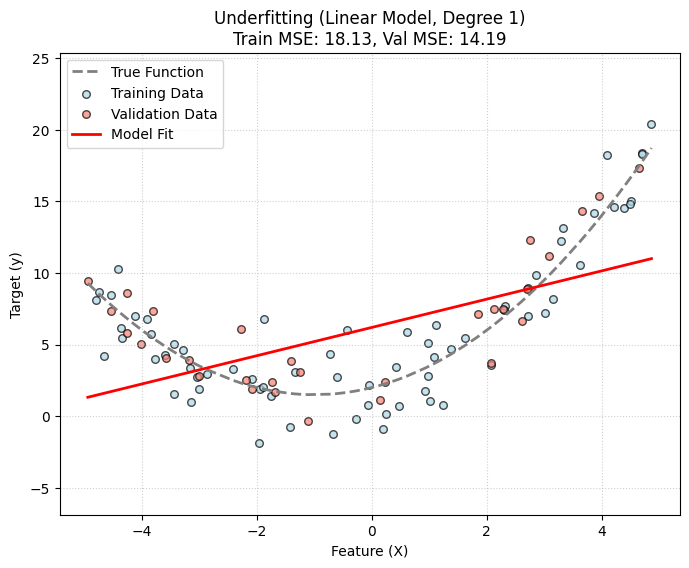

Underfit model (linear) shows high error on both training and validation sets.
------------------------------


In [5]:
# --- 2. Scenario 1: Underfitting (High Bias) ---
# Fit a simple linear model (degree 1 polynomial) to non-linear data.
print("--- Scenario 1: Underfitting ---")
# Create a pipeline: 1. PolynomialFeatures (degree=1), 2. LinearRegression
# Note: No scaling needed here as PolynomialFeatures handles it implicitly for LR
underfit_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=1, include_bias=False)),
    ('lin_reg', LinearRegression())
])

underfit_pipeline.fit(X_train, y_train)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_regression_fit(ax, underfit_pipeline, X_train, y_train, X_val_sorted, y_val_sorted, "Underfitting (Linear Model, Degree 1)")
plt.show()
print("Underfit model (linear) shows high error on both training and validation sets.")
print("-" * 30)

--- Scenario 2: Overfitting ---


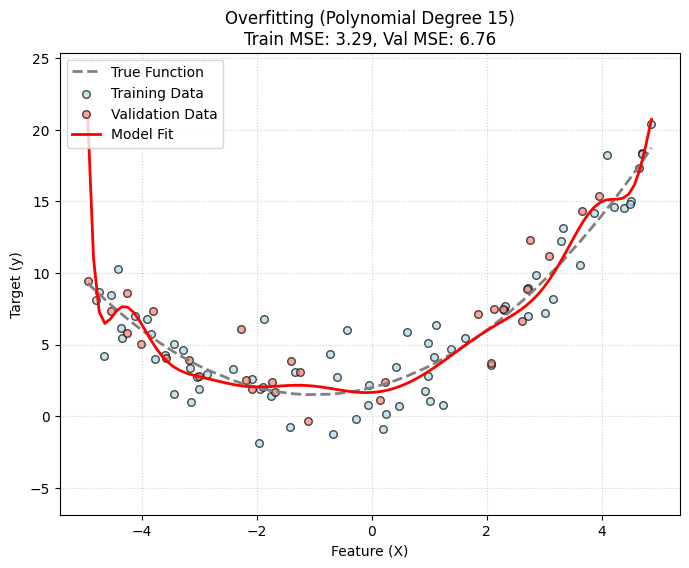

Overfit model (high degree) fits training data very closely (low train error)
but performs poorly on validation data (high validation error) due to fitting noise.
------------------------------


In [6]:
# --- 3. Scenario 2: Overfitting (High Variance) ---
# Fit a very complex model (high-degree polynomial) to the data.
print("--- Scenario 2: Overfitting ---")
overfit_degree = 15 # High degree polynomial
overfit_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=overfit_degree, include_bias=False)),
    # Note: Scaling becomes important with high-degree polynomials to avoid numerical issues
    ('scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

overfit_pipeline.fit(X_train, y_train)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_regression_fit(ax, overfit_pipeline, X_train, y_train, X_val_sorted, y_val_sorted, f"Overfitting (Polynomial Degree {overfit_degree})")
plt.show()
print("Overfit model (high degree) fits training data very closely (low train error)")
print("but performs poorly on validation data (high validation error) due to fitting noise.")
print("-" * 30)

--- Scenario 3: Good Fit ---


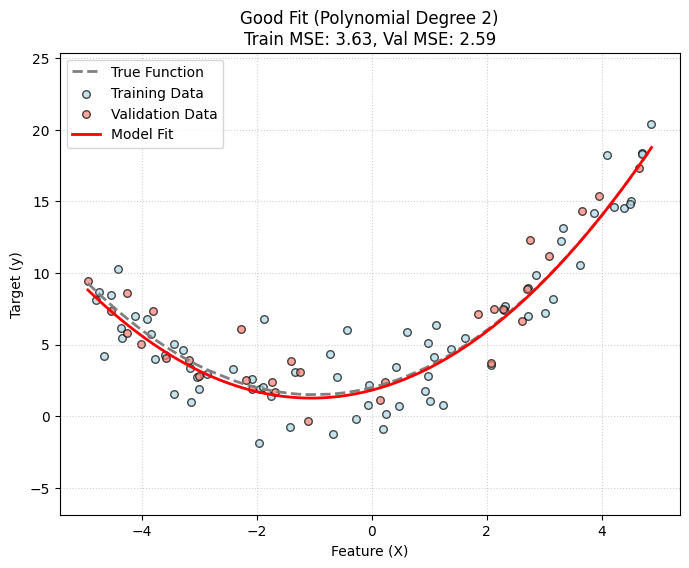

Good fit model captures the underlying trend, performing well on both train and validation sets.
------------------------------


In [7]:
# --- 4. Scenario 3: Good Fit (Balanced Bias-Variance) ---
# Fit a model with appropriate complexity (degree 2 polynomial, matching the true function).
print("--- Scenario 3: Good Fit ---")
good_fit_degree = 2
good_fit_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=good_fit_degree, include_bias=False)),
    ('scaler', StandardScaler()), # Scaling still good practice
    ('lin_reg', LinearRegression())
])

good_fit_pipeline.fit(X_train, y_train)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_regression_fit(ax, good_fit_pipeline, X_train, y_train, X_val_sorted, y_val_sorted, f"Good Fit (Polynomial Degree {good_fit_degree})")
plt.show()
print("Good fit model captures the underlying trend, performing well on both train and validation sets.")
print("-" * 30)

In [8]:
# --- 5. Learning Curves (Brief Mention - Section IX) ---
# Learning curves explicitly plot training and validation scores against the number
# of training samples. They are a powerful tool to diagnose bias/variance.
# - Underfitting: Both curves plateau at low score (high error). More data doesn't help much.
# - Overfitting: Large gap between high training score and lower validation score. More data might help curves converge.
# - Good Fit: Both curves converge to a high score (low error) with a small gap.

# Example of generating learning curve data (plotting requires separate code)
# train_sizes, train_scores, validation_scores = learning_curve(
#     estimator=good_fit_pipeline, X=X, y=y, train_sizes=np.linspace(0.1, 1.0, 10),
#     cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#
# # Calculate mean and standard deviation for training set scores
# train_mean = -np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
#
# # Calculate mean and standard deviation for test set scores
# validation_mean = -np.mean(validation_scores, axis=1)
# validation_std = np.std(validation_scores, axis=1)
#
# # Plotting code would go here... showing train_mean and validation_mean vs train_sizes

print("--- Learning Curves ---")
print("Learning curves (Section IX) provide a more formal way to visualize")
print("how training/validation scores change with data size, helping diagnose bias/variance.")
print("-" * 30)

--- Learning Curves ---
Learning curves (Section IX) provide a more formal way to visualize
how training/validation scores change with data size, helping diagnose bias/variance.
------------------------------
